Generating dataset...
Initializing model...
Training model...
Epoch [5/30], Loss: 0.6889, Val Accuracy: 0.5890
Epoch [10/30], Loss: 0.6260, Val Accuracy: 0.5840
Epoch [15/30], Loss: 0.4281, Val Accuracy: 0.9490
Epoch [20/30], Loss: 0.0028, Val Accuracy: 1.0000
Epoch [25/30], Loss: 0.0000, Val Accuracy: 1.0000
Epoch [30/30], Loss: -0.0000, Val Accuracy: 1.0000
Training time: 0.57 seconds

Testing model...
Test Accuracy: 1.0000


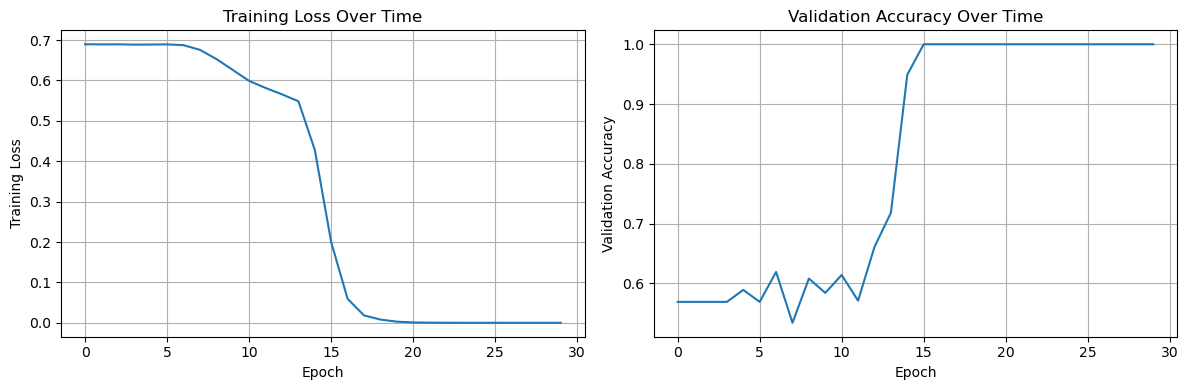


--- Example Predictions ---

Example 1:
Input sequence:  [0 1 0 1 0 1 1 0 1 0]
Target outputs:  [0 1 1 0 0 1 0 0 1 1]
Predicted:       [0 1 1 0 0 1 0 0 1 1]
✓ Correct prediction

Example 2:
Input sequence:  [0 0 1 1 0 0 1 1 1 0]
Target outputs:  [0 0 1 0 0 0 1 0 1 1]
Predicted:       [0 0 1 0 0 0 1 0 1 1]
✓ Correct prediction

Example 3:
Input sequence:  [0 0 0 0 1 0 1 1 0 1]
Target outputs:  [0 0 0 0 1 1 0 1 1 0]
Predicted:       [0 0 0 0 1 1 0 1 1 0]
✓ Correct prediction


In [14]:
import numpy as np
import matplotlib.pyplot as plt
import time

# Generate binary counter dataset
def generate_binary_counter(num_sequences=1000, seq_length=10):
    """Generate binary counter dataset for RNN testing"""
    data = []
    for _ in range(num_sequences):
        # Random binary sequence
        inputs = np.random.randint(0, 2, seq_length).tolist()
        outputs = []
        for t in range(seq_length):
            # Count 1s up to current position (inclusive), take modulo 2
            outputs.append(sum(inputs[:t+1]) % 2)
        data.append({
            'inputs': inputs,
            'outputs': outputs
        })
    return data

# Activation functions
def tanh(x):
    return np.tanh(x)

def tanh_derivative(x):
    return 1 - np.tanh(x)**2

def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=-1, keepdims=True))
    return exp_x / np.sum(exp_x, axis=-1, keepdims=True)

# RNN Model in NumPy
class NumpyRNN:
    def __init__(self, input_size=1, hidden_size=16, output_size=2, lr=0.01):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.lr = lr
        
        # Initialize weights
        self.Wxh = np.random.randn(input_size, hidden_size) * 0.1
        self.Whh = np.random.randn(hidden_size, hidden_size) * 0.1
        self.bh = np.zeros((1, hidden_size))
        
        self.Why = np.random.randn(hidden_size, output_size) * 0.1
        self.by = np.zeros((1, output_size))
        
        # Adam optimizer parameters
        self.mWxh, self.vWxh = np.zeros_like(self.Wxh), np.zeros_like(self.Wxh)
        self.mWhh, self.vWhh = np.zeros_like(self.Whh), np.zeros_like(self.Whh)
        self.mbh, self.vbh = np.zeros_like(self.bh), np.zeros_like(self.bh)
        self.mWhy, self.vWhy = np.zeros_like(self.Why), np.zeros_like(self.Why)
        self.mby, self.vby = np.zeros_like(self.by), np.zeros_like(self.by)
        self.beta1, self.beta2 = 0.9, 0.999
        self.epsilon = 1e-8
        self.t = 0
    
    def forward(self, X):
        """
        Forward pass through RNN
        X: (batch_size, seq_length, input_size)
        """
        batch_size, seq_length, _ = X.shape
        
        # Store hidden states and pre-activations
        self.hidden_states = np.zeros((batch_size, seq_length + 1, self.hidden_size))
        self.pre_activations = np.zeros((batch_size, seq_length, self.hidden_size))
        outputs = np.zeros((batch_size, seq_length, self.output_size))
        
        for t in range(seq_length):
            # Hidden state computation
            self.pre_activations[:, t] = (
                X[:, t] @ self.Wxh + 
                self.hidden_states[:, t] @ self.Whh + 
                self.bh
            )
            self.hidden_states[:, t + 1] = tanh(self.pre_activations[:, t])
            
            # Output computation
            outputs[:, t] = self.hidden_states[:, t + 1] @ self.Why + self.by
        
        return outputs
    
    def backward(self, X, y_true, y_pred):
        """
        Backward pass through RNN
        """
        batch_size, seq_length, _ = X.shape
        
        # Initialize gradients
        dWxh = np.zeros_like(self.Wxh)
        dWhh = np.zeros_like(self.Whh)
        dbh = np.zeros_like(self.bh)
        dWhy = np.zeros_like(self.Why)
        dby = np.zeros_like(self.by)
        
        # Convert y_true to one-hot
        y_one_hot = np.zeros((batch_size, seq_length, self.output_size))
        for b in range(batch_size):
            for t in range(seq_length):
                y_one_hot[b, t, y_true[b, t]] = 1
        
        # Gradient of loss w.r.t output
        y_prob = softmax(y_pred.reshape(-1, self.output_size)).reshape(batch_size, seq_length, self.output_size)
        dy = (y_prob - y_one_hot) / batch_size
        
        dh_next = np.zeros((batch_size, self.hidden_size))
        
        for t in reversed(range(seq_length)):
            # Output layer gradients
            dWhy += self.hidden_states[:, t + 1].T @ dy[:, t]
            dby += np.sum(dy[:, t], axis=0, keepdims=True)
            
            # Hidden state gradient
            dh = dy[:, t] @ self.Why.T + dh_next
            
            # Gradient through tanh
            dh_raw = dh * tanh_derivative(self.pre_activations[:, t])
            
            # Input-to-hidden gradients
            dWxh += X[:, t].T @ dh_raw
            dWhh += self.hidden_states[:, t].T @ dh_raw
            dbh += np.sum(dh_raw, axis=0, keepdims=True)
            
            # Gradient for next timestep
            dh_next = dh_raw @ self.Whh.T
        
        return dWxh, dWhh, dbh, dWhy, dby
    
    def update_weights(self, dWxh, dWhh, dbh, dWhy, dby):
        """Adam optimizer update"""
        self.t += 1
        
        # List of parameters and their gradients
        params = [self.Wxh, self.Whh, self.bh, self.Why, self.by]
        grads = [dWxh, dWhh, dbh, dWhy, dby]
        m_params = [self.mWxh, self.mWhh, self.mbh, self.mWhy, self.mby]
        v_params = [self.vWxh, self.vWhh, self.vbh, self.vWhy, self.vby]
        
        for i in range(len(params)):
            # Update biased first moment estimate
            m_params[i] = self.beta1 * m_params[i] + (1 - self.beta1) * grads[i]
            # Update biased second moment estimate
            v_params[i] = self.beta2 * v_params[i] + (1 - self.beta2) * (grads[i] ** 2)
            # Compute bias-corrected estimates
            m_hat = m_params[i] / (1 - self.beta1 ** self.t)
            v_hat = v_params[i] / (1 - self.beta2 ** self.t)
            # Update parameters
            params[i] -= self.lr * m_hat / (np.sqrt(v_hat) + self.epsilon)
    
    def compute_loss(self, y_pred, y_true):
        """Cross-entropy loss"""
        batch_size, seq_length = y_true.shape
        y_pred_flat = y_pred.reshape(-1, self.output_size)
        y_true_flat = y_true.reshape(-1)
        
        # Compute softmax probabilities
        probs = softmax(y_pred_flat)
        
        # Cross-entropy loss
        loss = 0
        for i in range(len(y_true_flat)):
            loss -= np.log(probs[i, y_true_flat[i]] + 1e-8)
        
        return loss / len(y_true_flat)
    
    def predict(self, X):
        """Get predictions"""
        outputs = self.forward(X)
        return np.argmax(outputs, axis=-1)

def prepare_batch(data, batch_indices):
    """Prepare batch from data"""
    batch_size = len(batch_indices)
    seq_length = len(data[0]['inputs'])
    
    X = np.zeros((batch_size, seq_length, 1))
    y = np.zeros((batch_size, seq_length), dtype=np.int32)
    
    for i, idx in enumerate(batch_indices):
        X[i, :, 0] = data[idx]['inputs']
        y[i, :] = data[idx]['outputs']
    
    return X, y

def train_model(model, train_data, val_data, epochs=30, batch_size=32):
    """Training loop"""
    num_batches = len(train_data) // batch_size
    train_losses = []
    val_accuracies = []
    
    for epoch in range(epochs):
        # Shuffle training data
        indices = np.random.permutation(len(train_data))
        epoch_loss = 0
        
        # Training
        for batch_idx in range(num_batches):
            batch_indices = indices[batch_idx * batch_size:(batch_idx + 1) * batch_size]
            X_batch, y_batch = prepare_batch(train_data, batch_indices)
            
            # Forward pass
            y_pred = model.forward(X_batch)
            loss = model.compute_loss(y_pred, y_batch)
            epoch_loss += loss
            
            # Backward pass
            grads = model.backward(X_batch, y_batch, y_pred)
            model.update_weights(*grads)
        
        avg_loss = epoch_loss / num_batches
        train_losses.append(avg_loss)
        
        # Validation
        val_correct = 0
        val_total = 0
        for i in range(0, len(val_data), batch_size):
            batch_indices = range(i, min(i + batch_size, len(val_data)))
            X_val, y_val = prepare_batch(val_data, batch_indices)
            predictions = model.predict(X_val)
            val_correct += np.sum(predictions == y_val)
            val_total += y_val.size
        
        accuracy = val_correct / val_total
        val_accuracies.append(accuracy)
        
        if (epoch + 1) % 5 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}, Val Accuracy: {accuracy:.4f}')
    
    return train_losses, val_accuracies

# Main execution
if __name__ == "__main__":
    # Set random seed
    np.random.seed(42)
    
    # Generate dataset
    print("Generating dataset...")
    train_data = generate_binary_counter(num_sequences=800, seq_length=10)
    val_data = generate_binary_counter(num_sequences=100, seq_length=10)
    test_data = generate_binary_counter(num_sequences=100, seq_length=10)
    
    # Initialize model
    print("Initializing model...")
    model = NumpyRNN(input_size=1, hidden_size=16, output_size=2, lr=0.01)
    
    # Train model
    print("Training model...")
    start_time = time.time()
    train_losses, val_accuracies = train_model(model, train_data, val_data, epochs=30, batch_size=32)
    training_time = time.time() - start_time
    print(f"Training time: {training_time:.2f} seconds")
    
    # Test model
    print("\nTesting model...")
    test_correct = 0
    test_total = 0
    examples = []
    
    for i in range(0, len(test_data), 32):
        batch_indices = range(i, min(i + 32, len(test_data)))
        X_test, y_test = prepare_batch(test_data, batch_indices)
        predictions = model.predict(X_test)
        test_correct += np.sum(predictions == y_test)
        test_total += y_test.size
        
        # Store first few examples
        if i == 0:
            for j in range(min(3, len(batch_indices))):
                examples.append({
                    'input': X_test[j, :, 0],
                    'target': y_test[j],
                    'prediction': predictions[j]
                })
    
    test_accuracy = test_correct / test_total
    print(f"Test Accuracy: {test_accuracy:.4f}")
    
    # Plot training curves
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    ax1.plot(train_losses)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Training Loss')
    ax1.set_title('Training Loss Over Time')
    ax1.grid(True)
    
    ax2.plot(val_accuracies)
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Validation Accuracy')
    ax2.set_title('Validation Accuracy Over Time')
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Display example predictions
    print("\n--- Example Predictions ---")
    for i, ex in enumerate(examples):
        print(f"\nExample {i+1}:")
        print(f"Input sequence:  {ex['input'].astype(int)}")
        print(f"Target outputs:  {ex['target']}")
        print(f"Predicted:       {ex['prediction']}")
        
        if np.array_equal(ex['target'], ex['prediction']):
            print("✓ Correct prediction")
        else:
            print("✗ Incorrect prediction")